In [13]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from joblib import dump, load

### Data Preprocessing & Anomaly Detection

In [14]:
def renameColumns(df): # rename the target columns
  df = df.rename(columns={'pCR (outcome)': 'PCR', 'RelapseFreeSurvival (outcome)': 'RFS'})
  df = df.dropna(subset=['PCR'])
  df = df.reset_index(drop=True)
  return df

def replaceWithNaN(df): # replace 999 values with nan
  '''Replace 999 with nan'''
  return df.replace(999, np.nan)

def getOnlyTumourColumns(df): # get only tumour columns
  '''Returns a df with only tumour (original_) columns from the input df.'''
  tumour_col_names = []
  for i in list(df.columns):
    if "original_" in i:
      tumour_col_names.append(i)
  return df[tumour_col_names]

def removeAnomalies(df):
  # Remove coarseness is 1000000
  anomaly_ids = []
  for i, data in enumerate(df["original_ngtdm_Coarseness"]):
    if data == 1000000:
      anomaly_ids.append(df["ID"][i])
  df["outlier"] = df["ID"].isin(anomaly_ids)
  df = df[df["outlier"] == False]
  df = df.drop("outlier", axis=1)
  df.reset_index(inplace=True, drop=True)

  # Remove items based on isolation forest
  df_tumour = getOnlyTumourColumns(df)

  clf = IsolationForest(random_state=42)
  clf.fit(df_tumour)
  anomaly_scores = clf.decision_function(df_tumour)

  df["outlier_score"] = anomaly_scores
  df = df[df['outlier_score'] >= -0.05] # remove rows with outlier_score < -0.5

  df.reset_index(inplace=True, drop=True)
  df = df.drop(["outlier_score"], axis=1)

  return df

def group_based_imputation(df, feature, groupby_col='PCR'): # do group based imputation using the mode (most frequent) value
    imputer = SimpleImputer(strategy='most_frequent')
    df.loc[:, feature] = df.groupby(groupby_col)[feature].transform(lambda x: imputer.fit_transform(x.values.reshape(-1, 1)).flatten())
    return df

def inputeMissingValues(df):
  # group based on PCR groups & fill missing values with mode
  missing_cols = ['PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType', 'LNStatus', 'Gene']
  for col in missing_cols:
      df.loc[df['PCR'].isna() == False] = group_based_imputation(df.loc[df['PCR'].isna() == False], col)
  return df

def fill_na_median(df_test):
  df_test = df_test.replace(999, np.nan)
  df_test = df_test.fillna(df_test.median(numeric_only=True))
  return df_test


df_train = pd.read_excel('TrainDataset2024.xls')
df_train = replaceWithNaN(df_train)
df_train = renameColumns(df_train)
df_train = removeAnomalies(df_train)
df_train = inputeMissingValues(df_train)

### PCA

In [15]:
#reduces tumour columns to 8 principle components
def pca(X):
    X_tumour = X.drop(X.columns[:11], axis=1)
    #print(X_tumour.columns)
    X = X.drop(X_tumour.columns,axis=1)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_tumour)
    components = 8
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(Xs)
    pca_df = pd.DataFrame(X_pca)
    pca_df.rename(mapper=lambda x: f'pca_{x}', inplace=True, axis=1)
    df = X.join(pca_df)
    return df, pca, scaler


def pca_classification(df):
  X = df.drop(['ID', 'PCR', 'RFS'], axis=1)
  y = df['PCR']
  X_pca, pca_returned, scaler_returned = pca(X)
  X_train,X_test,y_train,y_test = train_test_split(X_pca, y, test_size=0.3, random_state=1, stratify=y)
  return X_train, X_test, y_train, y_test, pca_returned, scaler_returned


### SVC Classification Model Training

Best balanced accuracy with hyperparameter tuning: 0.7333702882483369
Best parameters with hyperparameter tuning: {'C': 1.0, 'kernel': 'linear'}
Balanced accuracy score on Test Set: 0.807


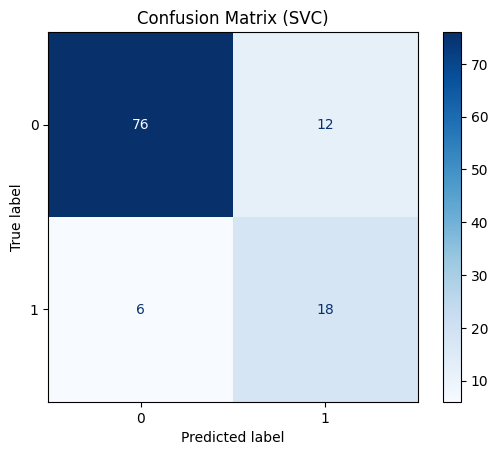

['svc_classification.joblib']

In [16]:
X_train, X_test, y_train, y_test, pca_returned, scaler_returned = pca_classification(df_train)
param_grid = { # parameters for SVC to use in grid search
    'C': np.arange(0.1,1.5,0.1),
    'kernel': ['linear','rbf','sigmoid']
}

grid_search = GridSearchCV(SVC(gamma='auto', degree=3),
                           param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

best_svc_clf = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best balanced accuracy with hyperparameter tuning:", grid_search.best_score_)
print("Best parameters with hyperparameter tuning:", best_params)

best_svc_clf.fit(X_train, y_train)
y_pred = best_svc_clf.predict(X_test)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy score on Test Set: {round(balanced_acc, 3)}")

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (SVC)")
plt.show()

dump(best_svc_clf, 'svc_classification.joblib')


### Final Test PCR Prediction

In [10]:
# FINAL TEST

df_test = pd.read_excel('FinalTestDataset2024.xls')
df_test = fill_na_median(df_test) # fill missing values with median
df_test_tumour = getOnlyTumourColumns(df_test)
df_test_clinical = df_test.drop(df_test_tumour.columns, axis=1)
ids = df_test_clinical['ID']
X_test_tumour = scaler_returned.transform(df_test_tumour)
X_test_pca = pca_returned.transform(X_test_tumour)
tumour_test_df = pd.DataFrame(X_test_pca)
tumour_test_df.rename(mapper=lambda x: f'pca_{x}', inplace=True, axis=1)
df_test = df_test_clinical.join(tumour_test_df)
df_test.drop('ID', axis=1, inplace=True)

pred_pcr = best_svc_clf.predict(df_test)

pcr_results = pd.DataFrame({'ID': ids, 'PCR': pred_pcr})

pcr_results.to_csv('PCRPrediction.csv', index=False) # save the predictions
